## PPC_ML

In [21]:
import glob

In [22]:
#path to processed data file
data_path='../../data/ML/ml_145_U1.29e+02_I4.72e+02_min_uc20_sc20'

Sparsity Variance: 0.02


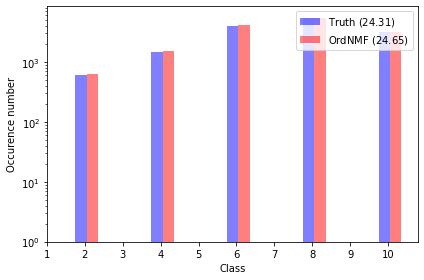

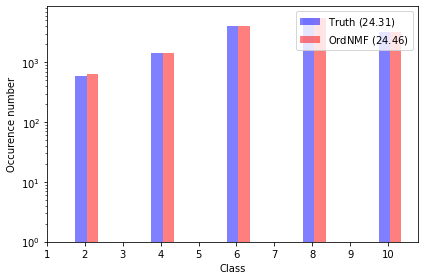

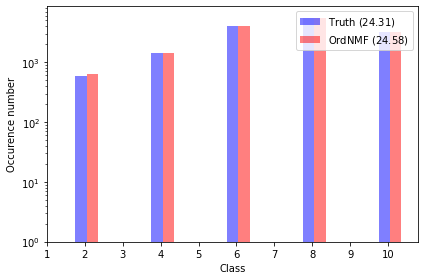

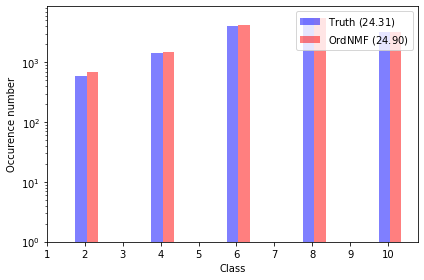

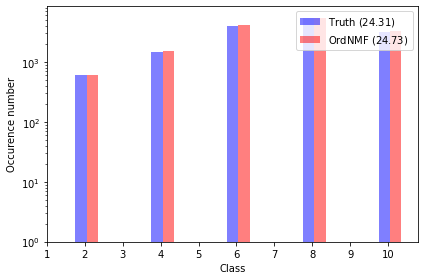

In [41]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
@author: ogouvert
"""

import os
import pickle as pickle
import scipy.sparse as sparse
import numpy as np
import sys

sys.path.append("../../model/OrdNMF")
sys.path.append("../../function")

from OrdNMF import Ord_generate

import preprocess_data  as prep

import matplotlib.pyplot as plt

#%%
prop_test = 0.2
seed_test = 1001


with open(data_path, 'rb') as f:
    out = pickle.load(f)
    Y = out['Y_listen']

U,I = Y.shape
T = Y.max()

Y_train,Y_test = prep.divide_train_test(Y,prop_test=prop_test,seed=seed_test)
save_dir = './out/seed_%d' %(seed_test)
y = Y_train.data
D = float(U*I)

####################
info = np.unique(y,return_counts=True)
sparsity_truth = Y_train.nnz/D*100.
index_truth = info[0]
h_truth = info[1]

sparcitys = []
i = 0
for filename in glob.glob(save_dir + '/*'): 
    #print(save_dir, filename)

    ####################
    #%% OrdNMF
    with open(os.path.join(filename),'rb') as f:
        model = pickle.load(f)
        
    W = model.Ew
    H = model.Eh
    L = W.dot(H.T)

    theta = model.theta

    #%%
    np.random.seed(0)

    Yppc = Ord_generate(L,theta[:-1])
    Yppc = sparse.csr_matrix(Yppc)
    yppc = Yppc.data

    #%%
    info = np.unique(yppc,return_counts=True)
    index_onmf = info[0]
    h_ppc_onmf = info[1]
    sparsity_onmf = Yppc.nnz/D*100.

    ####################
    #%% PLOT 
    n_groups = 10

    # create plot
    fig, ax = plt.subplots()
    ax.set_yscale('log')

    index = np.arange(n_groups)
    bar_width = 0.3
    opacity = .5

    sparcitys.append(sparsity_onmf)

    rects1 = ax.bar(index_truth, h_truth, bar_width,
                    bottom=1,
                    alpha=opacity,color='b',
                    label=r"Truth ($%.2f$)"%sparsity_truth)
    rects2 = ax.bar(index_onmf + bar_width, h_ppc_onmf, bar_width,
                    bottom=1,
                    alpha=opacity,color='r',
                    label=r"OrdNMF ($%.2f$)"%sparsity_onmf)

    plt.xlabel('Class')
    plt.ylabel("Occurence number")
    plt.xticks(index+1.1 ,np.arange(n_groups)+1)
    plt.legend(loc=1)

    plt.tight_layout()
    plt.savefig('./fig/PPC_ML' + str(i) + '.pdf',format='pdf', dpi=1200)
    i += 1
print("Sparity Variance: %.2f"%np.var(sparcitys))

## Score_ML

In [40]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
@author: ogouvert
"""

import os
import glob
import pandas as pd
import pickle as pickle
import numpy as np
import sys

sys.path.append("../../model/OrdNMF")
sys.path.append("../../model/dcPF")
sys.path.append("../../function")
np.seterr(divide='ignore', invalid='ignore')

from scipy.stats import poisson
import preprocess_data  as prep
import rec_eval

#%% Pre-processed data 

with open(data_path, 'rb') as f:
    out = pickle.load(f)
    Y = out['Y_listen']

U,I = Y.shape
T = Y.max()

#%%
prop_test = 0.2
Seed_train_test = [1001] # seed

for seed_train_test in Seed_train_test:
    Y_train,Y_test = prep.divide_train_test(Y,prop_test=prop_test,seed=seed_train_test)
    u,i = Y_test.nonzero()
    yt = (Y_test.data[:,np.newaxis] == np.arange(T+1)[np.newaxis,:])

    save_dir = './out/seed_%d' %(seed_train_test)

    for filename in glob.glob(os.path.join(save_dir,'*')):
        save=False
        with open(filename,'rb') as f:
            model = pickle.load(f)
            W = model.Ew
            H = model.Eh
        for s in range(10):
            if ~np.isin('ndcg@100s'+str(s), model.score.keys()):
                save=True
                ndcg = rec_eval.normalized_dcg_at_k(Y_train>0,Y_test>s,W,H,k=100)
                model.score['ndcg@100s'+str(s)]=ndcg
        if save == True:
            model.save_dir = save_dir
            model.save_model()

#%% Read scores
appended_data =[]
for seed_train_test in Seed_train_test:
    save_dir = './out/seed_%d' %(seed_train_test)
    for filename in glob.glob(os.path.join(save_dir,'*')):  
        with open(filename,'rb') as f:
            model = pickle.load(f)
        df_name = pd.DataFrame.from_dict([{'filename':filename, 
                                           'classname':model.classname}])
        df_init = pd.DataFrame.from_dict([model.saved_args_init])
        df_fit = pd.DataFrame.from_dict([model.saved_args_fit])
        df_score = pd.DataFrame.from_dict([model.score])
        df_loc = pd.concat([df_name,df_init,df_fit,df_score], axis=1)
        if model.classname =='dcpf_Log':
            df_loc['en moyen'] = model.En.data.mean()
            df_loc['T'] = 0
            df_loc['approx'] = False
        else:
            df_loc['en moyen'] = model.En.mean()
        appended_data.append(df_loc)
      
if appended_data != []:
    df = pd.concat(appended_data, axis=0)

#%%
columns = [u'classname', u'filename', u'prefix',
        u'K', u'T', u'approx', 
        u'en moyen',
        u'ndcg@100s0', u'ndcg@100s3',u'ndcg@100s5',
        u'ndcg@100s7', u'ndcg@100s9']
        #, u'loglik'
df = df[columns] 

res_mean = df.groupby(['classname','prefix','T','approx','K']).mean().reset_index()

#%%
sc = 'ndcg@100s7'
idx = res_mean.groupby(['classname','prefix','T','approx'])[sc].transform(max) == res_mean[sc]
res_mean = res_mean[idx]


res_var = df.groupby(['classname','prefix','T','approx','K']).var().reset_index()
#%%
sc = 'ndcg@100s7'
idx = res_var.groupby(['classname','prefix','T','approx'])[sc].transform(max) == res_var[sc]
res_var = res_var[idx]

print("Mean results for 5 training seeds:\n", res_mean.to_string(index=False), '\n')
print("Variance of results for 5 training seeds:\n",res_var.to_string(index=False))

Mean results for 5 training seeds:
 classname prefix   T  approx    K  en moyen  ndcg@100s0  ndcg@100s3  ndcg@100s5  ndcg@100s7  ndcg@100s9
   OrdNMF     ML  10   False  150  1.084365    0.546056     0.54549     0.54259    0.512332    0.421954 

Variance of results for 5 training seeds:
 classname prefix   T  approx    K  en moyen  ndcg@100s0  ndcg@100s3  ndcg@100s5  ndcg@100s7  ndcg@100s9
   OrdNMF     ML  10   False  150  0.000012    0.000062    0.000059    0.000059    0.000048    0.000028
